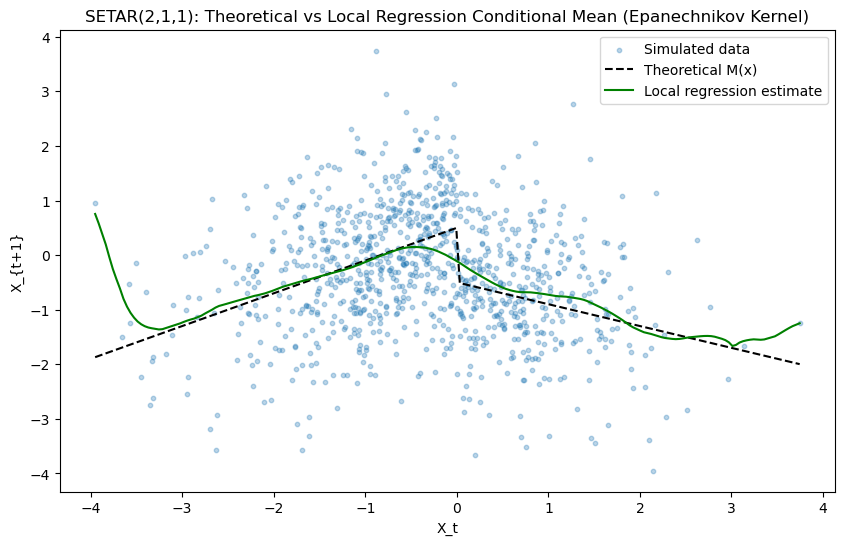

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import WLS
import statsmodels.api as sm

# ---------------------------------------------
# Simulate SETAR function
# ---------------------------------------------
def simulate_setar(n=1000, a0_1=0, a1_1=0.5, a0_2=0, a1_2=-0.5, threshold=0):
    np.random.seed(25)
    X = np.zeros(n)
    r = np.random.normal(0, 1, n)

    for t in range(1, n):
        if X[t-1] <= threshold:
            X[t] = a0_1 + a1_1 * X[t-1] + r[t]
        else:
            X[t] = a0_2 + a1_2 * X[t-1] + r[t]
    return X

def M_theoretical(x):
    return np.where(x <= threshold, a0_1 + a1_1*x, a0_2 + a1_2*x)

def epanechnikov_kernel(u, h):
    u_scaled = u / h
    mask = np.abs(u_scaled) <= 1  
    w = np.zeros_like(u)
    w[mask] = 0.75 * (1 - u_scaled[mask]**2) / h
    return w

def lm(x0, X, Y, h):
    u = (X - x0) / h
    w = epanechnikov_kernel(u,h)
    X_mat = sm.add_constant(X)
    model = WLS(Y, X_mat, weights=w)
    results = model.fit()
    y0 = results.params[0] + results.params[1]*x0
    return y0

# SETAR(2;1;1) parameters
a0_1, a1_1 = 0.5, 0.6
a0_2, a1_2 = -0.5, -0.4
threshold = 0
n = 1000

# Simulate data
X = simulate_setar(n, a0_1, a1_1, a0_2, a1_2, threshold)
X_lag = X[:-1]
X_next = X[1:]

# Compute conditional mean
h = 0.11 * (np.max(X) - np.min(X))

x_grid = np.linspace(np.min(X), np.max(X), 200)
Mc_est = np.array([lm(x0, X_lag, X_next, h) for x0 in x_grid])

# Theoretic mean
M_x = M_theoretical(x_grid)


# ---------------------------------------------
# Plot
# ---------------------------------------------
plt.figure(figsize=(10,6))
plt.scatter(X_lag, X_next, alpha=0.3, s=10, label='Simulated data')
plt.plot(x_grid, M_x, 'k--', label='Theoretical M(x)')
plt.plot(x_grid, Mc_est, 'g', label='Local regression estimate')
plt.xlabel('X_t')
plt.ylabel('X_{t+1}')
plt.title('SETAR(2,1,1): Theoretical vs Local Regression Conditional Mean (Epanechnikov Kernel)')
plt.legend()
plt.show()


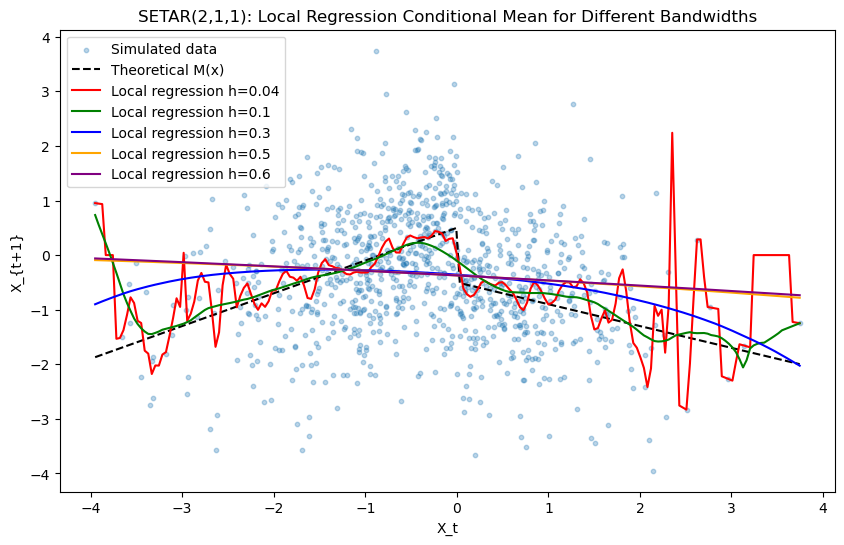

In [2]:
# ---------------------------------------------
# Trying Different Bandwidths
# ---------------------------------------------
bandwidths = [0.04, 0.1, 0.3, 0.5, 0.6]  

plt.figure(figsize=(10,6))
plt.scatter(X_lag, X_next, alpha=0.3, s=10, label='Simulated data')

plt.plot(x_grid, M_x, 'k--', label='Theoretical M(x)')

colors = ['r', 'g', 'b', 'orange', 'purple']
for h_frac, color in zip(bandwidths, colors):
    h = h_frac * (np.max(X) - np.min(X))
    Mc_est = np.array([lm(x0, X_lag, X_next, h) for x0 in x_grid])
    plt.plot(x_grid, Mc_est, color=color, label=f'Local regression h={h_frac}')

plt.xlabel('X_t')
plt.ylabel('X_{t+1}')
plt.title('SETAR(2,1,1): Local Regression Conditional Mean for Different Bandwidths')
plt.legend()
plt.show()


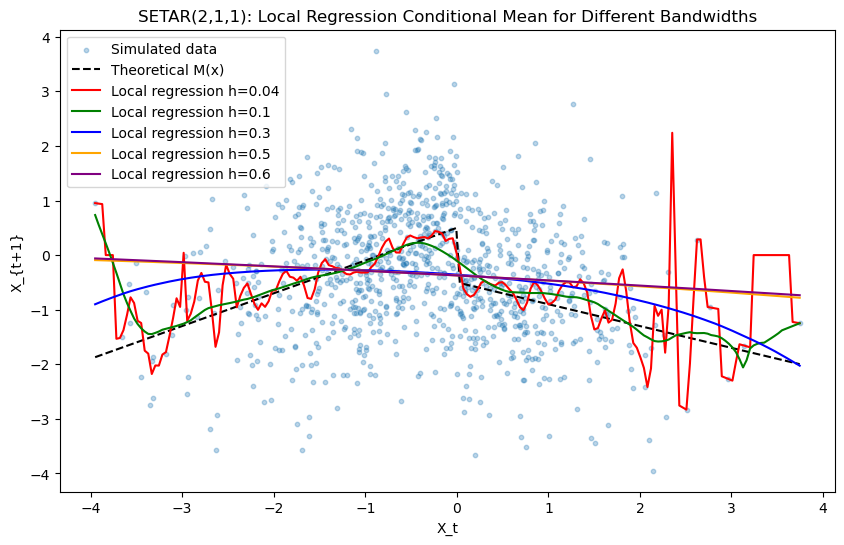

In [3]:
# Try different bandwidths
bandwidth= np.linspace(0.04, 0.6, 9)  

plt.figure(figsize=(10,6))
plt.scatter(X_lag, X_next, alpha=0.3, s=10, label='Simulated data')

plt.plot(x_grid, M_x, 'k--', label='Theoretical M(x)')

colors = ['r', 'g', 'b', 'orange', 'purple']
for h_frac, color in zip(bandwidths, colors):
    h = h_frac * (np.max(X) - np.min(X))
    Mc_est = np.array([lm(x0, X_lag, X_next, h) for x0 in x_grid])
    plt.plot(x_grid, Mc_est, color=color, label=f'Local regression h={h_frac}')

plt.xlabel('X_t')
plt.ylabel('X_{t+1}')
plt.title('SETAR(2,1,1): Local Regression Conditional Mean for Different Bandwidths')
plt.legend()
plt.show()

h=0.040, MSE=1.2084
h=0.110, MSE=1.1187
h=0.180, MSE=1.1688
h=0.250, MSE=1.2032
h=0.320, MSE=1.2550
h=0.390, MSE=1.2786
h=0.460, MSE=1.2871
h=0.530, MSE=1.2909
h=0.600, MSE=1.2927


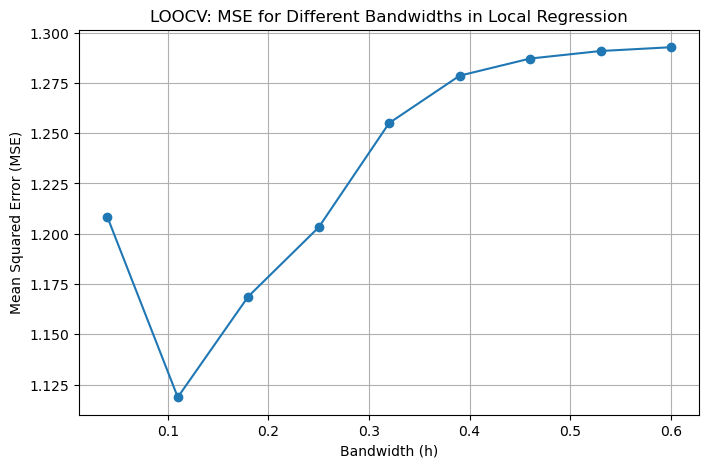

In [4]:
import statsmodels.api as sm

# ----------------------------------------------------------
# Leave-one-out cross-validation for bandwidth selection
# ----------------------------------------------------------
def loocv_bandwidth_selection(X_lag, X_next, bandwidths):
    n = len(X_lag)
    mse_list = []

    for h_frac in bandwidths:
        h = h_frac * (np.max(X_lag) - np.min(X_lag))
        errors = []

        for i in range(n):
            X_train = np.delete(X_lag, i)
            Y_train = np.delete(X_next, i)
            x0 = X_lag[i]
            y_true = X_next[i]
            y_pred = lm(x0, X_train, Y_train, h)

            errors.append((y_true - y_pred)**2)

        mse = np.mean(errors)
        mse_list.append(mse)
        print(f"h={h_frac:.3f}, MSE={mse:.4f}")

    best_idx = np.argmin(mse_list)
    best_h = bandwidths[best_idx]
    return best_h, mse_list

bandwidth_candidates = np.linspace(0.04, 0.6, 9)  
best_h, mse_list = loocv_bandwidth_selection(X_lag, X_next, bandwidth_candidates)

plt.figure(figsize=(8,5))
plt.plot(bandwidth_candidates, mse_list, marker='o', linestyle='-')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LOOCV: MSE for Different Bandwidths in Local Regression')
plt.grid(True)
plt.show()

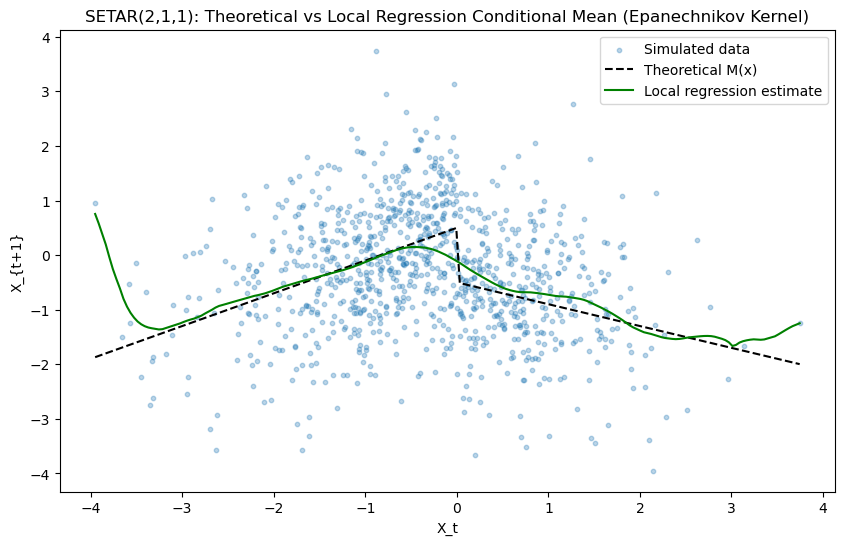

In [6]:
# ----------------------------------------------------------
# Plot Selected Bandwidth: h = 0.11
# ----------------------------------------------------------
X = simulate_setar(n, a0_1, a1_1, a0_2, a1_2, threshold)
X_lag = X[:-1]
X_next = X[1:]
h = 0.11 * (np.max(X) - np.min(X))

x_grid = np.linspace(np.min(X), np.max(X), 200)
Mc_est = np.array([lm(x0, X_lag, X_next, h) for x0 in x_grid])
M_x = M_theoretical(x_grid)

plt.figure(figsize=(10,6))
plt.scatter(X_lag, X_next, alpha=0.3, s=10, label='Simulated data')
plt.plot(x_grid, M_x, 'k--', label='Theoretical M(x)')
plt.plot(x_grid, Mc_est, 'g', label='Local regression estimate')
plt.xlabel('X_t')
plt.ylabel('X_{t+1}')
plt.title('SETAR(2,1,1): Theoretical vs Local Regression Conditional Mean (Epanechnikov Kernel)')
plt.legend()
plt.show()